In [2]:
data_dir = 'D:\\projects\\ev_detection\data\\f28e28af-5e8b-44e4-bf01-e85eb1c221fb\\load'

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
print(onlyfiles[0])

0016d991-8fc4-4a43-9d27-d50304b03791.csv


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import time
from PyEMD import EMD,Visualisation
import matplotlib.dates as mdates

In [5]:
def select_imfs(imfs):
    #
    shape_input = imfs.shape
    idx_start = shape_input[0]-1
    detrending_imf = np.zeros((1,shape_input[-1]),dtype=float)
    #
    interval = np.amax(imfs,axis=1)-np.amin(imfs,axis=1)
    for idx_start in range(shape_input[0]-1,0,-1):
        detrending_imf+=imfs[idx_start,:]
        if interval[idx_start]==max(interval):
            break
    return detrending_imf

In [6]:
%%time
for ii in range(0,2,1):
    rnd = np.random.randint(0,len(onlyfiles),2)
    pd1 = pd.read_csv(join(data_dir,onlyfiles[rnd[0]]),sep=';',parse_dates=[0],date_parser=lambda col: pd.to_datetime(col, utc=True))
    pd1 = pd1.set_index('date_tz')
    pd1 = pd1[~pd1.index.duplicated()]
    m1 = pd1['kWh/h'].mean()
    pd1['kWh/h'] = pd1['kWh/h']-m1
    pd1_rs = pd1.resample(rule='W',axis=0).mean()
    emd1 = EMD()
    emd1.FIXE = 10
    imfs1 = emd1(pd1_rs['kWh/h'])
    imfs1_pd=pd.DataFrame.from_records(np.transpose(select_imfs(imfs1)),index=pd1_rs.index,columns=['imf'])
    pd1_new = pd1_rs.merge(right=imfs1_pd,left_index=True,right_index=True)
    imfs1_pd_hr = imfs1_pd.resample(rule='H',axis=0).interpolate(method='linear')
    pd1=pd1.merge(right=imfs1_pd_hr,left_index=True,right_index=True)
    pd1['detrend']=pd1['kWh/h']-pd1['imf']
    pd1['detrend_norm']=(pd1['detrend']-pd1['detrend'].min())/(pd1['detrend'].max()-pd1['detrend'].min())
    pd1['kWh/h_norm']=(pd1['kWh/h']-pd1['kWh/h'].min())/(pd1['kWh/h'].max()-pd1['kWh/h'].min())
    fig=plt.figure
    pd1.loc[(pd1.index.hour>15) & (pd1.index.hour<22)]['kWh/h_norm'].hist(bins=128,color='r')
    pd1.loc[(pd1.index.hour>15) & (pd1.index.hour<22)]['detrend_norm'].hist(bins=128)
    plt.savefig(f'{onlyfiles[rnd[0]]}.png')
    plt.close()

C:\bin\anaconda3\envs\EV_DETECTION\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
C:\bin\anaconda3\envs\EV_DETECTION\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


Wall time: 1.85 s


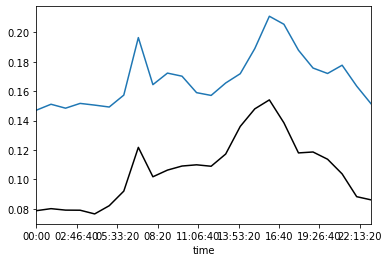

In [8]:
pd1.groupby(pd1.index.time).std()['kWh/h_norm'].plot()
pd1.groupby(pd1.index.time).std()['detrend_norm'].plot(color='k')

In [36]:
before=pd1.groupby(pd1.index.time).mean()['kWh/h_norm']
after=pd1.groupby(pd1.index.time).mean()['detrend_norm']
bf_std = pd1.groupby(pd1.index.time).std()['kWh/h_norm']
aft_std = pd1.groupby(pd1.index.time).std()['detrend_norm']

Text(0.5, 1.0, 'Average daily profile')

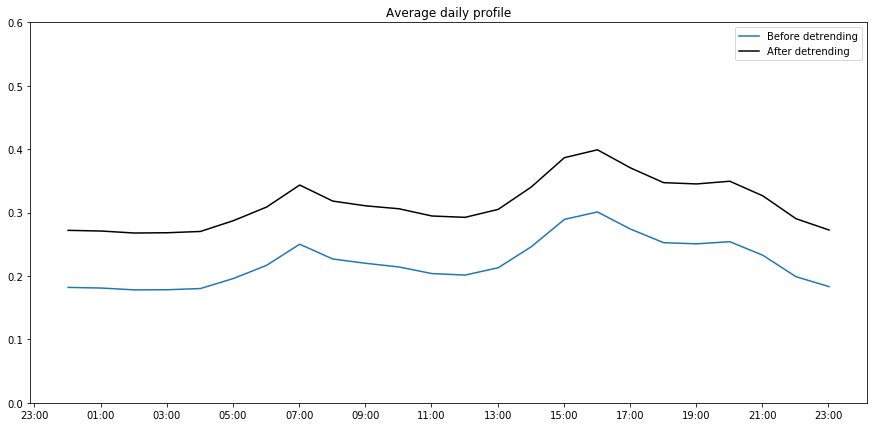

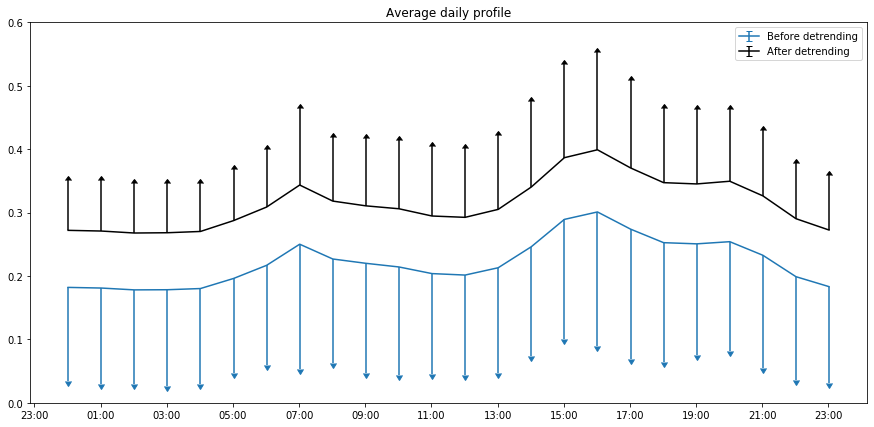

In [52]:
fig, ax = plt.subplots(figsize=(15,7))
hours = mdates.HourLocator(interval = 2)   # every hour
hours_fmt = mdates.DateFormatter('%H:%M')
idx = pd.date_range('2017-01-01 00:01', '2017-01-01 23:59', freq = 'H')
plt.plot(idx,before,label='Before detrending')
plt.plot(idx,after,color='k',label='After detrending')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.set_ylim([0, 0.6])
ax.legend()
ax.set_title('Average daily profile')
fig, ax = plt.subplots(figsize=(15,7))
hours = mdates.HourLocator(interval = 2)   # every hour
hours_fmt = mdates.DateFormatter('%H:%M')
idx = pd.date_range('2017-01-01 00:01', '2017-01-01 23:59', freq = 'H')
plt.errorbar(idx,before,yerr=bf_std,label='Before detrending',uplims=True)
plt.errorbar(idx,after,yerr=aft_std,color='k',label='After detrending',lolims=True)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.set_ylim([0, 0.6])
ax.legend()
ax.set_title('Average daily profile')

Text(0.5, 1.0, 'Coefficient of variation : 100 x sigma/mu')

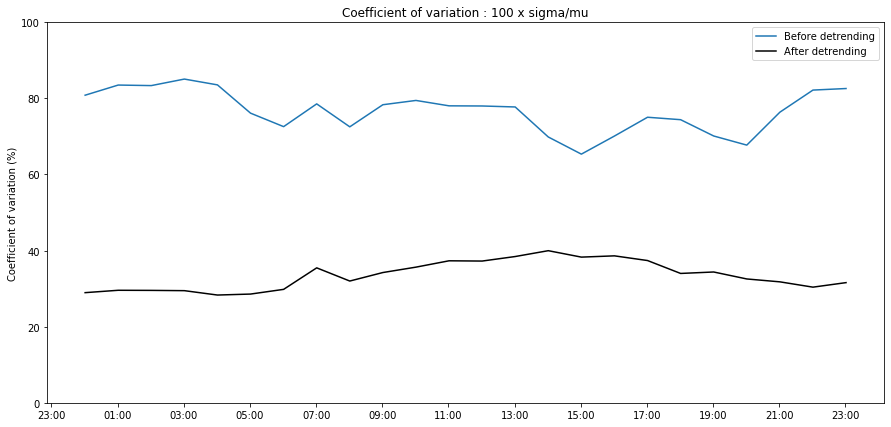

In [64]:
from matplotlib import rc
rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(15,7))
hours = mdates.HourLocator(interval = 2)   # every hour
hours_fmt = mdates.DateFormatter('%H:%M')
idx = pd.date_range('2017-01-01 00:01', '2017-01-01 23:59', freq = 'H')
plt.plot(idx,100*bf_std/before,label='Before detrending')
plt.plot(idx,100*aft_std/after,color='k',label='After detrending')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.set_ylim([0, 100])
ax.legend()
ax.set_ylabel('Coefficient of variation (%)')
ax.set_title('Coefficient of variation : 100 x sigma/mu')

In [11]:
weekend = np.where(pd1.index.weekday < 5, 'Weekday', 'Weekend')
by_time = pd1.groupby([weekend, pd1.index.time]).mean()

<ErrorbarContainer object of 3 artists>

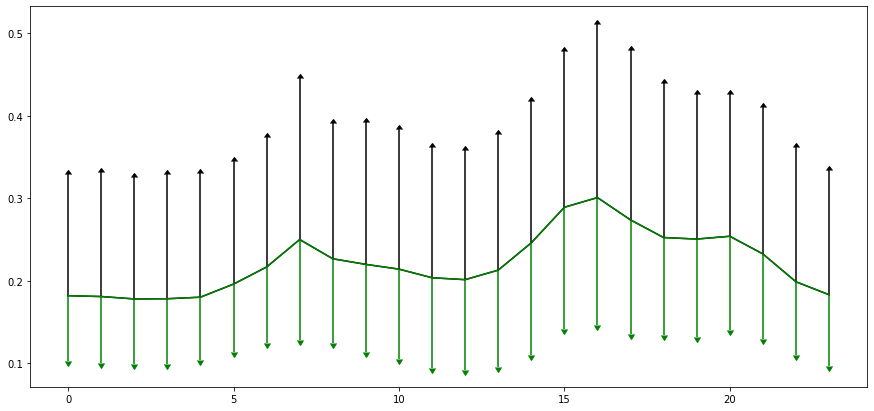

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
vec=[]
ss = []
vec2=[]
ss2 = []
for d in pd1.groupby(pd1.index.time).groups:
    #fig,ax = plt.subplots(figsize=(6,6))
    vec.append(pd1.loc[pd1.index.time==d,'kWh/h_norm'].mean())
    ss.append(pd1.loc[pd1.index.time==d,'kWh/h_norm'].std())
    vec2.append(pd1.loc[pd1.index.time==d,'detrend_norm'].mean())
    ss2.append(pd1.loc[pd1.index.time==d,'detrend_norm'].std())
plt.errorbar(range(0,24,1),vec,yerr=ss,color='k',lolims=True)
plt.errorbar(range(0,24,1),vec,yerr=ss2,color='g',uplims=True)

In [27]:
hours()

[]